**Training Deep Neural Networks**

# Setup

First, let's import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures. We also check that Python 3.5 or later is installed (although Python 2.x may work, it is deprecated so we strongly recommend you use Python 3 instead), as well as Scikit-Learn ≥0.20 and TensorFlow ≥2.0.

In [ ]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

%load_ext tensorboard

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "deep"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Vanishing/Exploding Gradients Problem

Let's train a neural network on Fashion MNIST using the Leaky ReLU:

In [ ]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full / 255.0
X_test = X_test / 255.0
X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

4431872/4422102 [==============================] - 0s 0us/step


Now let's train it. Do not forget to scale the inputs to mean 0 and standard deviation 1:

In [ ]:
pixel_means = X_train.mean(axis=0, keepdims=True)
pixel_stds = X_train.std(axis=0, keepdims=True)
X_train_scaled = (X_train - pixel_means) / pixel_stds
X_valid_scaled = (X_valid - pixel_means) / pixel_stds
X_test_scaled = (X_test - pixel_means) / pixel_stds

# Avoiding Overfitting Through Regularization

## $\ell_1$ and $\ell_2$ regularization

https://towardsdatascience.com/intuitions-on-l1-and-l2-regularisation-235f2db4c261

1. The l2() function returns a regularizer that will be called at each step during training to compute the regularization loss. This is then added to the final loss. 

2. As you might expect, you can just use keras.regularizers.l1() if you want ℓ1 regularization; 

3. if you want both ℓ1 and ℓ2 regularization, use keras.regularizers.l1_l2() (specifying both regularization factors).

In [ ]:
layer = keras.layers.Dense(100, activation="elu",
                           kernel_initializer="he_normal",
                           kernel_regularizer=keras.regularizers.l2(0.01))
# or l1(0.1) for ℓ1 regularization with a factor or 0.1
# or l1_l2(0.1, 0.01) for both ℓ1 and ℓ2 regularization, with factors 0.1 and 0.01 respectively

In [ ]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="elu",
                       kernel_initializer="he_normal",
                       kernel_regularizer=keras.regularizers.l2(0.01)),
    keras.layers.Dense(100, activation="elu",
                       kernel_initializer="he_normal",
                       kernel_regularizer=keras.regularizers.l2(0.01)),
    keras.layers.Dense(10, activation="softmax",
                       kernel_regularizer=keras.regularizers.l2(0.01))
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 2
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/2
55000/55000 [==============================] - 7s 130us/sample - loss: 1.5735 - accuracy: 0.8126 - val_loss: 0.7327 - val_accuracy: 0.8222
Epoch 2/2
55000/55000 [==============================] - 6s 115us/sample - loss: 0.7186 - accuracy: 0.8260 - val_loss: 0.6929 - val_accuracy: 0.8338


we can  use Python’s functools.partial() function,
which lets you create a thin wrapper for any callable, with some default argument values as shown below

In [ ]:
from functools import partial

RegularizedDense = partial(keras.layers.Dense,
                           activation="elu",
                           kernel_initializer="he_normal",
                           kernel_regularizer=keras.regularizers.l2(0.01))

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    RegularizedDense(300),
    RegularizedDense(100),
    RegularizedDense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 2
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/2
55000/55000 [==============================] - 7s 133us/sample - loss: 1.6006 - accuracy: 0.8129 - val_loss: 0.7374 - val_accuracy: 0.8236
Epoch 2/2
55000/55000 [==============================] - 7s 128us/sample - loss: 0.7179 - accuracy: 0.8265 - val_loss: 0.6905 - val_accuracy: 0.8356


## Dropout

 With dropout regularization, at each ***training iteration a random subset of
all neurons in one or more layers—except the output layer—are “dropped out”; these neurons output 0 at this iteration ***

 Suppose drop out rate is p = 50%, in which case during testing, a neuron would be connected to twice as many input neurons as it would be (on average) during training.

 To compensate for this fact, we need to multiply each neuron’s input ***connection weights by 0.5 after training.***  If we don’t, each
neuron will get a total input signal roughly twice as large as what the network was trained on and will be unlikely to perform well. 

More generally, we need to ***multiply each input connection weight by the keep probability (1 – p) after training.***

 Alternatively, we can*** divide each neuron’s output by the keep probability during training*** (these alternatives are not perfectly equivalent, but they work equally well).

In [ ]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(300, activation="elu", kernel_initializer="he_normal"),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(100, activation="elu", kernel_initializer="he_normal"),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 2
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
1719/1719 [==============================] - 12s 7ms/step - loss: 0.5708 - accuracy: 0.8056 - val_loss: 0.3886 - val_accuracy: 0.8580
Epoch 2/2
1719/1719 [==============================] - 10s 6ms/step - loss: 0.4222 - accuracy: 0.8451 - val_loss: 0.3391 - val_accuracy: 0.8716


## Alpha Dropout

Applies Alpha Dropout to the input.

 Alpha Dropout is a Dropout that ***keeps mean and variance of inputs to their original values, in order to ensure the self-normalizing property even after this dropout.***
 
  Alpha Dropout fits well to Scaled Exponential Linear Units by randomly setting activations to the negative saturation value. 



In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

In [ ]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.AlphaDropout(rate=0.2),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.AlphaDropout(rate=0.2),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.AlphaDropout(rate=0.2),
    keras.layers.Dense(10, activation="softmax")
])
optimizer = keras.optimizers.SGD(lr=0.01, momentum=0.9, nesterov=True)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
n_epochs = 20
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/20
55000/55000 [==============================] - 3s 55us/sample - loss: 0.6616 - accuracy: 0.7616 - val_loss: 0.6682 - val_accuracy: 0.8258
Epoch 2/20
55000/55000 [==============================] - 3s 49us/sample - loss: 0.5526 - accuracy: 0.7969 - val_loss: 0.5835 - val_accuracy: 0.8382
Epoch 3/20
55000/55000 [==============================] - 3s 48us/sample - loss: 0.5259 - accuracy: 0.8060 - val_loss: 0.5312 - val_accuracy: 0.8512
Epoch 4/20
55000/55000 [==============================] - 3s 49us/sample - loss: 0.5076 - accuracy: 0.8111 - val_loss: 0.4969 - val_accuracy: 0.8606
Epoch 5/20
55000/55000 [==============================] - 3s 47us/sample - loss: 0.4929 - accuracy: 0.8175 - val_loss: 0.4875 - val_accuracy: 0.8610
Epoch 6/20
55000/55000 [==============================] - 3s 48us/sample - loss: 0.4844 - accuracy: 0.8190 - val_loss: 0.5141 - val_accuracy: 0.8552
Epoch 7/20
55000/55000 [==============================] -

In [ ]:
model.evaluate(X_test_scaled, y_test)

10000/10000 [==============================] - 0s 25us/sample - loss: 0.4736 - accuracy: 0.8648


[0.47358015085458754, 0.8648]

In [ ]:
model.evaluate(X_train_scaled, y_train)

55000/55000 [==============================] - 1s 22us/sample - loss: 0.3532 - accuracy: 0.8859


[0.35321958436965945, 0.8859091]

In [ ]:
history = model.fit(X_train_scaled, y_train)

Train on 55000 samples
55000/55000 [==============================] - 2s 44us/sample - loss: 0.4186 - accuracy: 0.8451


## MC Dropout

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

## syntax for prediction for keras model

for small inputs prediction the syntax

```model(X_test_scaled, training=True)```

We just make 100 predictions over the test set, setting training=True to ensure that the Dropout layer is active, and stack the predictions.

 Since dropout is active, all the
predictions will be different. Recall that predict() returns a matrix with one row per instance and one column per class. Because there are 10,000 instances in the test set
and 10 classes, this is a matrix of shape [10000, 10]. We stack 100 such matrices, so
y_probas is an array of shape [100, 10000, 10]. Once we average over the first
dimension (axis=0), we get y_proba, an array of shape [10000, 10], like we would get
with a single prediction. That’s all! Averaging over multiple predictions with dropout
on gives us a Monte Carlo estimate that is generally more reliable than the result of a
single prediction with dropout off.

In [ ]:
y_probas = np.stack([model(X_test_scaled, training=True)
                     for sample in range(100)])
y_proba = y_probas.mean(axis=0)
y_std = y_probas.std(axis=0)

 For example, let’s look at the model’s prediction
for the first instance in the Fashion MNIST test set, with dropout off:

In [ ]:
np.round(model.predict(X_test_scaled[:1]), 2)

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.1 , 0.  , 0.29, 0.  , 0.61]],
      dtype=float32)

The model seems almost certain that this image belongs to class 9 (ankle boot).
Should you trust it? Is there really so little room for doubt? Compare this with the
predictions made when dropout is activated:

In [ ]:
np.round(y_probas[:, :1], 2)

array([[[0.  , 0.  , 0.  , 0.  , 0.  , 0.29, 0.  , 0.58, 0.  , 0.13]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.03, 0.  , 0.22, 0.  , 0.75]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.12, 0.  , 0.16, 0.  , 0.72]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.06, 0.  , 0.16, 0.  , 0.78]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.09, 0.  , 0.13, 0.  , 0.77]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.1 , 0.  , 0.65, 0.  , 0.25]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.02, 0.  , 0.16, 0.  , 0.82]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.26, 0.  , 0.33, 0.  , 0.42]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.07, 0.  , 0.28, 0.  , 0.64]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.08, 0.  , 0.16, 0.  , 0.76]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.11, 0.  , 0.75, 0.  , 0.14]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.33, 0.  , 0.51, 0.  , 0.16]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.13, 0.  , 0.48, 0.  , 0.38]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.02, 0.  , 0.03, 0.  , 0

This tells a very different story: apparently, when we activate dropout, the model is
not sure anymore. It still seems to prefer class 9, but sometimes it hesitates with
classes 5 (sandal) and 7 (sneaker), which makes sense given they’re all footwear. Once
we average over the first dimension, we get the following MC Dropout predictions:

In [ ]:
np.round(y_proba[:1], 2)

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.2 , 0.  , 0.28, 0.  , 0.52]],
      dtype=float32)

The model still thinks this image belongs to class 9, but only with a 62% confidence,
which seems much more reasonable than 99%. Plus it’s useful to know exactly which
other classes it thinks are likely. And you can also take a look at the standard deviation
of the probability estimates:

In [ ]:
y_std = y_probas.std(axis=0)
np.round(y_std[:1], 2)

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.2 , 0.  , 0.2 , 0.02, 0.25]],
      dtype=float32)

Apparently there’s quite a lot of variance in the probability estimates: if you were
building a risk-sensitive system (e.g., a medical or financial system), you should probably
treat such an uncertain prediction with extreme caution. You definitely would
not treat it like a 99% confident prediction. Moreover, the model’s accuracy got a
small boost from 86.8 to 86.9:

In [ ]:
y_pred = np.argmax(y_proba, axis=1)

In [ ]:
accuracy = np.sum(y_pred == y_test) / len(y_test)
accuracy

0.8593

The number of Monte Carlo samples you use (100 in this example)
is a hyperparameter you can tweak. The higher it is, the more accurate
the predictions and their uncertainty estimates will be. However,
if you double it, inference time will also be doubled.
Moreover, above a certain number of samples, you will notice little
improvement. So your job is to find the right trade-off between
latency and accuracy, depending on your application.

If your model contains other layers that behave in a special way during training (such
as BatchNormalization layers), then you should not force training mode like we just
did. Instead, you should replace the Dropout layers with the following MCDropout
class:

In [ ]:
class MCDropout(keras.layers.Dropout):
    def call(self, inputs):
        return super().call(inputs, training=True)

class MCAlphaDropout(keras.layers.AlphaDropout):
    def call(self, inputs):
        return super().call(inputs, training=True)

Here, we just subclass the Dropout layer and override the call() method to force its
training argument to True (see Chapter 12). Similarly, you could define an MCAlpha
Dropout class by subclassing AlphaDropout instead. If you are creating a model from
scratch, it’s just a matter of using MCDropout rather than Dropout. But if you have a
model that was already trained using Dropout, you need to create a new model that’s
identical to the existing model except that it replaces the Dropout layers with MCDrop
out, then copy the existing model’s weights to your new model.
In short, MC Dropout is a fantastic technique that boosts dropout models and provides
better uncertainty estimates. And of course, since it is just regular dropout during
training, it also acts like a regularizer.

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

In [ ]:
mc_model = keras.models.Sequential([
    MCAlphaDropout(layer.rate) if isinstance(layer, keras.layers.AlphaDropout) else layer
    for layer in model.layers
])

In [ ]:
mc_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dropout (Dropout)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 300)               235500    
                                                                 
 dropout_1 (Dropout)         (None, 300)               0         
                                                                 
 dense_1 (Dense)             (None, 100)               30100     
                                                                 
 dropout_2 (Dropout)         (None, 100)               0         
                                                                 
 dense_2 (Dense)             (None, 10)               

In [ ]:
optimizer = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, nesterov=True)
mc_model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

In [ ]:
mc_model.set_weights(model.get_weights())

Now we can use the model with MC Dropout:

In [ ]:
np.round(np.mean([mc_model.predict(X_test_scaled[:1]) for sample in range(100)], axis=0), 2)

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.1 , 0.  , 0.29, 0.  , 0.61]],
      dtype=float32)

## Max norm

Another regularization technique that is popular for neural networks is called maxnorm
regularization: for each neuron, it constrains the weights w of the incoming
connections such that ∥ w ∥2 ≤ r, where r is the max-norm hyperparameter and ∥ · ∥2
is the ℓ2 norm.
Max-norm regularization does not add a regularization loss term to the overall loss
function. Instead, it is typically implemented by computing ∥w∥2 after each training
step and rescaling w if needed (w ← w r/‖ w ‖2).

Reducing r increases the amount of regularization and helps reduce overfitting. Maxnorm
regularization can also help alleviate the unstable gradients problems (if you
are not using Batch Normalization).
To implement max-norm regularization in Keras, set the kernel_constraint argument
of each hidden layer to a max_norm() constraint with the appropriate max value,
like this:


In [ ]:
layer = keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal",
                           kernel_constraint=keras.constraints.max_norm(1.))

After each training iteration, the model’s fit() method will call the object returned
by max_norm(), passing it the layer’s weights and getting rescaled weights in return,
which then replace the layer’s weights. As you’ll see in Chapter 12, you can define
your own custom constraint function if necessary and use it as the kernel_con
straint. You can also constrain the bias terms by setting the bias_constraint
argument.
The max_norm() function has an axis argument that defaults to 0. A Dense layer usually
has weights of shape [number of inputs, number of neurons], so using axis=0
means that the max-norm constraint will apply independently to each neuron’s
weight vector. If you want to use max-norm with convolutional layers (see Chapter
14), make sure to set the max_norm() constraint’s axis argument appropriately
(usually axis=[0, 1, 2]).

In [ ]:
from functools import partial

MaxNormDense = partial(keras.layers.Dense,
                       activation="selu", kernel_initializer="lecun_normal",
                       kernel_constraint=keras.constraints.max_norm(1.))

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    MaxNormDense(300),
    MaxNormDense(100),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 2
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
1719/1719 [==============================] - 12s 7ms/step - loss: 0.4741 - accuracy: 0.8337 - val_loss: 0.3711 - val_accuracy: 0.8638
Epoch 2/2
1719/1719 [==============================] - 11s 6ms/step - loss: 0.3566 - accuracy: 0.8711 - val_loss: 0.3563 - val_accuracy: 0.8740


# Exercises

## 1. to 7.

See appendix A.

## 8. Deep Learning on CIFAR10

### a.
*Exercise: Build a DNN with 20 hidden layers of 100 neurons each (that's too many, but it's the point of this exercise). Use He initialization and the ELU activation function.*

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[32, 32, 3]))
for _ in range(20):
    model.add(keras.layers.Dense(100,
                                 activation="elu",
                                 kernel_initializer="he_normal"))

### b.
*Exercise: Using Nadam optimization and early stopping, train the network on the CIFAR10 dataset. You can load it with `keras.datasets.cifar10.load_data()`. The dataset is composed of 60,000 32 × 32–pixel color images (50,000 for training, 10,000 for testing) with 10 classes, so you'll need a softmax output layer with 10 neurons. Remember to search for the right learning rate each time you change the model's architecture or hyperparameters.*

Let's add the output layer to the model:

In [ ]:
model.add(keras.layers.Dense(10, activation="softmax"))

Let's use a Nadam optimizer with a learning rate of 5e-5. I tried learning rates 1e-5, 3e-5, 1e-4, 3e-4, 1e-3, 3e-3 and 1e-2, and I compared their learning curves for 10 epochs each (using the TensorBoard callback, below). The learning rates 3e-5 and 1e-4 were pretty good, so I tried 5e-5, which turned out to be slightly better.

In [ ]:
optimizer = keras.optimizers.Nadam(lr=5e-5)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

Let's load the CIFAR10 dataset. We also want to use early stopping, so we need a validation set. Let's use the first 5,000 images of the original training set as the validation set:

In [ ]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.cifar10.load_data()

X_train = X_train_full[5000:]
y_train = y_train_full[5000:]
X_valid = X_train_full[:5000]
y_valid = y_train_full[:5000]

Now we can create the callbacks we need and train the model:

In [ ]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=20)
model_checkpoint_cb = keras.callbacks.ModelCheckpoint("my_cifar10_model.h5", save_best_only=True)
run_index = 1 # increment every time you train the model
run_logdir = os.path.join(os.curdir, "my_cifar10_logs", "run_{:03d}".format(run_index))
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
callbacks = [early_stopping_cb, model_checkpoint_cb, tensorboard_cb]

In [ ]:
%tensorboard --logdir=./my_cifar10_logs --port=6006

In [ ]:
model.fit(X_train, y_train, epochs=100,
          validation_data=(X_valid, y_valid),
          callbacks=callbacks)

Train on 45000 samples, validate on 5000 samples
Epoch 1/100
45000/45000 [==============================] - 9s 208us/sample - loss: 4.0892 - accuracy: 0.1672 - val_loss: 2.1601 - val_accuracy: 0.2020
Epoch 2/100
45000/45000 [==============================] - 8s 175us/sample - loss: 2.0558 - accuracy: 0.2469 - val_loss: 1.9845 - val_accuracy: 0.2808
Epoch 3/100
45000/45000 [==============================] - 7s 161us/sample - loss: 1.9306 - accuracy: 0.2942 - val_loss: 1.9089 - val_accuracy: 0.2934
Epoch 4/100
45000/45000 [==============================] - 7s 157us/sample - loss: 1.8437 - accuracy: 0.3332 - val_loss: 1.7957 - val_accuracy: 0.3510
Epoch 5/100
45000/45000 [==============================] - 7s 162us/sample - loss: 1.7829 - accuracy: 0.3560 - val_loss: 1.7779 - val_accuracy: 0.3582
Epoch 6/100
45000/45000 [==============================] - 7s 154us/sample - loss: 1.7374 - accuracy: 0.3702 - val_loss: 1.8059 - val_accuracy: 0.3540
Epoch 7/100
45000/45000 [====================

In [ ]:
model = keras.models.load_model("my_cifar10_model.h5")
model.evaluate(X_valid, y_valid)

5000/5000 [==============================] - 0s 65us/sample - loss: 1.5099 - accuracy: 0.4736


[1.5099372177124024, 0.4736]

The model with the lowest validation loss gets about 47% accuracy on the validation set. It took 39 epochs to reach the lowest validation loss, with roughly 10 seconds per epoch on my laptop (without a GPU). Let's see if we can improve performance using Batch Normalization.

### c.
*Exercise: Now try adding Batch Normalization and compare the learning curves: Is it converging faster than before? Does it produce a better model? How does it affect training speed?*

The code below is very similar to the code above, with a few changes:

* I added a BN layer after every Dense layer (before the activation function), except for the output layer. I also added a BN layer before the first hidden layer.
* I changed the learning rate to 5e-4. I experimented with 1e-5, 3e-5, 5e-5, 1e-4, 3e-4, 5e-4, 1e-3 and 3e-3, and I chose the one with the best validation performance after 20 epochs.
* I renamed the run directories to run_bn_* and the model file name to my_cifar10_bn_model.h5.

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[32, 32, 3]))
model.add(keras.layers.BatchNormalization())
for _ in range(20):
    model.add(keras.layers.Dense(100, kernel_initializer="he_normal"))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Activation("elu"))
model.add(keras.layers.Dense(10, activation="softmax"))

optimizer = keras.optimizers.Nadam(lr=5e-4)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

early_stopping_cb = keras.callbacks.EarlyStopping(patience=20)
model_checkpoint_cb = keras.callbacks.ModelCheckpoint("my_cifar10_bn_model.h5", save_best_only=True)
run_index = 1 # increment every time you train the model
run_logdir = os.path.join(os.curdir, "my_cifar10_logs", "run_bn_{:03d}".format(run_index))
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
callbacks = [early_stopping_cb, model_checkpoint_cb, tensorboard_cb]

model.fit(X_train, y_train, epochs=100,
          validation_data=(X_valid, y_valid),
          callbacks=callbacks)

model = keras.models.load_model("my_cifar10_bn_model.h5")
model.evaluate(X_valid, y_valid)

Train on 45000 samples, validate on 5000 samples
Epoch 1/100
45000/45000 [==============================] - 21s 466us/sample - loss: 1.8365 - accuracy: 0.3390 - val_loss: 1.6330 - val_accuracy: 0.4174
Epoch 2/100
45000/45000 [==============================] - 16s 352us/sample - loss: 1.6623 - accuracy: 0.4063 - val_loss: 1.5967 - val_accuracy: 0.4204
Epoch 3/100
45000/45000 [==============================] - 16s 355us/sample - loss: 1.5946 - accuracy: 0.4314 - val_loss: 1.5225 - val_accuracy: 0.4602
Epoch 4/100
45000/45000 [==============================] - 17s 367us/sample - loss: 1.5417 - accuracy: 0.4551 - val_loss: 1.4680 - val_accuracy: 0.4756
Epoch 5/100
45000/45000 [==============================] - 17s 367us/sample - loss: 1.5013 - accuracy: 0.4678 - val_loss: 1.4378 - val_accuracy: 0.4862
Epoch 6/100
45000/45000 [==============================] - 16s 361us/sample - loss: 1.4637 - accuracy: 0.4797 - val_loss: 1.4221 - val_accuracy: 0.4982
Epoch 7/100
45000/45000 [==============

[1.305354326057434, 0.5506]

* *Is the model converging faster than before?* Much faster! The previous model took 39 epochs to reach the lowest validation loss, while the new model with BN took 18 epochs. That's more than twice as fast as the previous model. The BN layers stabilized training and allowed us to use a much larger learning rate, so convergence was faster.
* *Does BN produce a better model?* Yes! The final model is also much better, with 55% accuracy instead of 47%. It's still not a very good model, but at least it's much better than before (a Convolutional Neural Network would do much better, but that's a different topic, see chapter 14).
* *How does BN affect training speed?* Although the model converged twice as fast, each epoch took about 16s instead of 10s, because of the extra computations required by the BN layers. So overall, although the number of epochs was reduced by 50%, the training time (wall time) was shortened by 30%. Which is still pretty significant!

### d.
*Exercise: Try replacing Batch Normalization with SELU, and make the necessary adjustements to ensure the network self-normalizes (i.e., standardize the input features, use LeCun normal initialization, make sure the DNN contains only a sequence of dense layers, etc.).*

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[32, 32, 3]))
for _ in range(20):
    model.add(keras.layers.Dense(100,
                                 kernel_initializer="lecun_normal",
                                 activation="selu"))
model.add(keras.layers.Dense(10, activation="softmax"))

optimizer = keras.optimizers.Nadam(lr=7e-4)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

early_stopping_cb = keras.callbacks.EarlyStopping(patience=20)
model_checkpoint_cb = keras.callbacks.ModelCheckpoint("my_cifar10_selu_model.h5", save_best_only=True)
run_index = 1 # increment every time you train the model
run_logdir = os.path.join(os.curdir, "my_cifar10_logs", "run_selu_{:03d}".format(run_index))
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
callbacks = [early_stopping_cb, model_checkpoint_cb, tensorboard_cb]

X_means = X_train.mean(axis=0)
X_stds = X_train.std(axis=0)
X_train_scaled = (X_train - X_means) / X_stds
X_valid_scaled = (X_valid - X_means) / X_stds
X_test_scaled = (X_test - X_means) / X_stds

model.fit(X_train_scaled, y_train, epochs=100,
          validation_data=(X_valid_scaled, y_valid),
          callbacks=callbacks)

model = keras.models.load_model("my_cifar10_selu_model.h5")
model.evaluate(X_valid_scaled, y_valid)

Train on 45000 samples, validate on 5000 samples
Epoch 1/100
45000/45000 [==============================] - 12s 268us/sample - loss: 1.9310 - accuracy: 0.3055 - val_loss: 1.7814 - val_accuracy: 0.3566
Epoch 2/100
45000/45000 [==============================] - 10s 216us/sample - loss: 1.7077 - accuracy: 0.3935 - val_loss: 1.9245 - val_accuracy: 0.3654
Epoch 3/100
45000/45000 [==============================] - 10s 219us/sample - loss: 1.6116 - accuracy: 0.4314 - val_loss: 1.6612 - val_accuracy: 0.4316
Epoch 4/100
45000/45000 [==============================] - 10s 219us/sample - loss: 1.5385 - accuracy: 0.4590 - val_loss: 1.5879 - val_accuracy: 0.4414
Epoch 5/100
45000/45000 [==============================] - 11s 234us/sample - loss: 1.4911 - accuracy: 0.4746 - val_loss: 1.5470 - val_accuracy: 0.4626
Epoch 6/100
45000/45000 [==============================] - 9s 205us/sample - loss: 1.4419 - accuracy: 0.4964 - val_loss: 1.5535 - val_accuracy: 0.4662
Epoch 7/100
45000/45000 [===============

[1.462584439086914, 0.514]

In [ ]:
model = keras.models.load_model("my_cifar10_selu_model.h5")
model.evaluate(X_valid_scaled, y_valid)

5000/5000 [==============================] - 0s 74us/sample - loss: 1.4626 - accuracy: 0.5140


[1.462584439086914, 0.514]

We get 51.4% accuracy, which is better than the original model, but not quite as good as the model using batch normalization. Moreover, it took 13 epochs to reach the best model, which is much faster than both the original model and the BN model, plus each epoch took only 10 seconds, just like the original model. So it's by far the fastest model to train (both in terms of epochs and wall time).

### e.
*Exercise: Try regularizing the model with alpha dropout. Then, without retraining your model, see if you can achieve better accuracy using MC Dropout.*

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[32, 32, 3]))
for _ in range(20):
    model.add(keras.layers.Dense(100,
                                 kernel_initializer="lecun_normal",
                                 activation="selu"))

model.add(keras.layers.AlphaDropout(rate=0.1))
model.add(keras.layers.Dense(10, activation="softmax"))

optimizer = keras.optimizers.Nadam(lr=5e-4)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

early_stopping_cb = keras.callbacks.EarlyStopping(patience=20)
model_checkpoint_cb = keras.callbacks.ModelCheckpoint("my_cifar10_alpha_dropout_model.h5", save_best_only=True)
run_index = 1 # increment every time you train the model
run_logdir = os.path.join(os.curdir, "my_cifar10_logs", "run_alpha_dropout_{:03d}".format(run_index))
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
callbacks = [early_stopping_cb, model_checkpoint_cb, tensorboard_cb]

X_means = X_train.mean(axis=0)
X_stds = X_train.std(axis=0)
X_train_scaled = (X_train - X_means) / X_stds
X_valid_scaled = (X_valid - X_means) / X_stds
X_test_scaled = (X_test - X_means) / X_stds

model.fit(X_train_scaled, y_train, epochs=100,
          validation_data=(X_valid_scaled, y_valid),
          callbacks=callbacks)

model = keras.models.load_model("my_cifar10_alpha_dropout_model.h5")
model.evaluate(X_valid_scaled, y_valid)

Train on 45000 samples, validate on 5000 samples
Epoch 1/100
45000/45000 [==============================] - 12s 263us/sample - loss: 1.8763 - accuracy: 0.3330 - val_loss: 1.7595 - val_accuracy: 0.3668
Epoch 2/100
45000/45000 [==============================] - 10s 219us/sample - loss: 1.6527 - accuracy: 0.4148 - val_loss: 1.7666 - val_accuracy: 0.3808
Epoch 3/100
45000/45000 [==============================] - 10s 219us/sample - loss: 1.5682 - accuracy: 0.4439 - val_loss: 1.6393 - val_accuracy: 0.4490
Epoch 4/100
45000/45000 [==============================] - 10s 211us/sample - loss: 1.5030 - accuracy: 0.4698 - val_loss: 1.6028 - val_accuracy: 0.4466
Epoch 5/100
45000/45000 [==============================] - 9s 209us/sample - loss: 1.4430 - accuracy: 0.4913 - val_loss: 1.5394 - val_accuracy: 0.4562
Epoch 6/100
45000/45000 [==============================] - 10s 215us/sample - loss: 1.4005 - accuracy: 0.5084 - val_loss: 1.5408 - val_accuracy: 0.4818
Epoch 7/100
45000/45000 [===============

[1.4974345008850098, 0.5082]

The model reaches 50.8% accuracy on the validation set. That's very slightly worse than without dropout (51.4%). With an extensive hyperparameter search, it might be possible to do better (I tried dropout rates of 5%, 10%, 20% and 40%, and learning rates 1e-4, 3e-4, 5e-4, and 1e-3), but probably not much better in this case.

Let's use MC Dropout now. We will need the `MCAlphaDropout` class we used earlier, so let's just copy it here for convenience:

In [ ]:
class MCAlphaDropout(keras.layers.AlphaDropout):
    def call(self, inputs):
        return super().call(inputs, training=True)

Now let's create a new model, identical to the one we just trained (with the same weights), but with `MCAlphaDropout` dropout layers instead of `AlphaDropout` layers:

In [ ]:
mc_model = keras.models.Sequential([
    MCAlphaDropout(layer.rate) if isinstance(layer, keras.layers.AlphaDropout) else layer
    for layer in model.layers
])

Then let's add a couple utility functions. The first will run the model many times (10 by default) and it will return the mean predicted class probabilities. The second will use these mean probabilities to predict the most likely class for each instance:

In [ ]:
def mc_dropout_predict_probas(mc_model, X, n_samples=10):
    Y_probas = [mc_model.predict(X) for sample in range(n_samples)]
    return np.mean(Y_probas, axis=0)

def mc_dropout_predict_classes(mc_model, X, n_samples=10):
    Y_probas = mc_dropout_predict_probas(mc_model, X, n_samples)
    return np.argmax(Y_probas, axis=1)

Now let's make predictions for all the instances in the validation set, and compute the accuracy:

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

y_pred = mc_dropout_predict_classes(mc_model, X_valid_scaled)
accuracy = np.mean(y_pred == y_valid[:, 0])
accuracy

0.5094

We only get virtually no accuracy improvement in this case (from 50.8% to 50.9%).

So the best model we got in this exercise is the Batch Normalization model.

### f.
*Exercise: Retrain your model using 1cycle scheduling and see if it improves training speed and model accuracy.*

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[32, 32, 3]))
for _ in range(20):
    model.add(keras.layers.Dense(100,
                                 kernel_initializer="lecun_normal",
                                 activation="selu"))

model.add(keras.layers.AlphaDropout(rate=0.1))
model.add(keras.layers.Dense(10, activation="softmax"))

optimizer = keras.optimizers.SGD(lr=1e-3)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

Train on 45000 samples
45000/45000 [==============================] - 3s 60us/sample - loss: nan - accuracy: 0.1403


[1e-05, 9.999868, 2.0895472, 3.482099260602679]

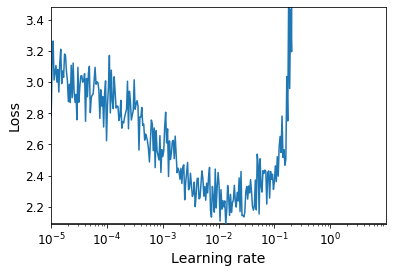

In [ ]:
batch_size = 128
rates, losses = find_learning_rate(model, X_train_scaled, y_train, epochs=1, batch_size=batch_size)
plot_lr_vs_loss(rates, losses)
plt.axis([min(rates), max(rates), min(losses), (losses[0] + min(losses)) / 1.4])

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[32, 32, 3]))
for _ in range(20):
    model.add(keras.layers.Dense(100,
                                 kernel_initializer="lecun_normal",
                                 activation="selu"))

model.add(keras.layers.AlphaDropout(rate=0.1))
model.add(keras.layers.Dense(10, activation="softmax"))

optimizer = keras.optimizers.SGD(lr=1e-2)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

In [ ]:
n_epochs = 15
onecycle = OneCycleScheduler(len(X_train_scaled) // batch_size * n_epochs, max_rate=0.05)
history = model.fit(X_train_scaled, y_train, epochs=n_epochs, batch_size=batch_size,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[onecycle])

Train on 45000 samples, validate on 5000 samples
Epoch 1/15
45000/45000 [==============================] - 3s 69us/sample - loss: 2.0504 - accuracy: 0.2823 - val_loss: 1.7711 - val_accuracy: 0.3706
Epoch 2/15
45000/45000 [==============================] - 3s 57us/sample - loss: 1.7626 - accuracy: 0.3766 - val_loss: 1.7751 - val_accuracy: 0.3844
Epoch 3/15
45000/45000 [==============================] - 3s 59us/sample - loss: 1.6264 - accuracy: 0.4272 - val_loss: 1.6774 - val_accuracy: 0.4216
Epoch 4/15
45000/45000 [==============================] - 3s 57us/sample - loss: 1.5527 - accuracy: 0.4474 - val_loss: 1.6633 - val_accuracy: 0.4316
Epoch 5/15
45000/45000 [==============================] - 3s 59us/sample - loss: 1.4997 - accuracy: 0.4701 - val_loss: 1.5909 - val_accuracy: 0.4540
Epoch 6/15
45000/45000 [==============================] - 3s 60us/sample - loss: 1.4564 - accuracy: 0.4841 - val_loss: 1.5982 - val_accuracy: 0.4624
Epoch 7/15
45000/45000 [==============================] -

One cycle allowed us to train the model in just 15 epochs, each taking only 3 seconds (thanks to the larger batch size). This is over 3 times faster than the fastest model we trained so far. Moreover, we improved the model's performance (from 50.8% to 52.8%). The batch normalized model reaches a slightly better performance, but it's much slower to train.